# PSI3532 - Filtragem Adaptativa e Aplicacoes
Experiencia 5 -Cancelamento de eco
----------------------------------------------------
Henrique Souza de Melo - 9347031

In [1]:
import numpy as np
from numpy import pi, cos, sqrt, zeros, log10
from numpy.random import randn

import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams.update({'font.size':14})

from scipy import signal
from scipy.io import wavfile

import h5py

import sounddevice as sd

from filters import LMS, NLMS, RLS

In [2]:
def exp5(a, mu_0, epsilon, L, total_time, N):
    n = np.arange(total_time)
    
    adaptation_delay = 100
    
    EMSE_LMS = zeros(total_time - adaptation_delay)
    EMSE_NLMS = zeros(total_time - adaptation_delay)
    EMSE_RLS = zeros(total_time - adaptation_delay)
    for i in range(N):
        sigma_u = sqrt(1)
        u = randn(total_time) * sigma_u
        x = signal.lfilter(b=[sqrt(1 - a ** 2)], a=[1, -a], x=u)
        sigma_x = sigma_u

        sigma_v = sqrt(.01)
        v = randn(total_time) * sigma_v

        h = randn(100)
        h = h / np.linalg.norm(h)
        
        y = signal.lfilter(b=h, a=1, x=x)

        d = y + v

        M = len(h)
        # setting mu value to approximate final EMSE values to compare algorithms
        lms_filter = LMS(M=M, mu=mu_0 / (M * sigma_x + epsilon))
        nlms_filter = NLMS(M=M, mu_0=mu_0, epsilon=epsilon)
        rls_filter = RLS(M=M, L=L, delta=1)

        for j in range(adaptation_delay, total_time):
            lms_filter.buffer(x[j], d[j])
            nlms_filter.buffer(x[j], d[j])
            rls_filter.buffer(x[j], d[j])

        sigma_o = sigma_v
        EMSE_LMS += (1 / N) * (np.square(lms_filter.e) - sigma_o ** 2)
        EMSE_NLMS += (1 / N) * (np.square(nlms_filter.e) - sigma_o ** 2)
        EMSE_RLS += (1 / N) * (np.square(rls_filter.e) - sigma_o ** 2)
        
    return n[adaptation_delay:], EMSE_LMS, EMSE_NLMS, EMSE_RLS

In [34]:
def plot_results(algorithm, e, MSD, v, y):
    ERLE = 10 * np.log10(y ** 2 / e ** 2)
    
    fig = plt.figure(figsize=(15,15))
    fig.suptitle('Resultados para o filtro {}'.format(algorithm))
    ax1 = plt.subplot(411)
    plt.plot(v)
    ax1.title.set_text('Sinal $v[n]$')
    ax2 = plt.subplot(412, sharex=ax1)
    plt.plot(e)
    ax2.title.set_text('Sinal $e[n]$')
    ax3 = plt.subplot(413, sharex=ax1)
    plt.semilogy(MSD)
    ax3.title.set_text('MSD')
    ax4 = plt.subplot(414, sharex=ax1)
    plt.plot(ERLE)
    ax4.title.set_text('Echo return loss enhancement')
    plt.xlabel('n')

## Sinal nao correlacionado

Text(0.5, 0, 'n')

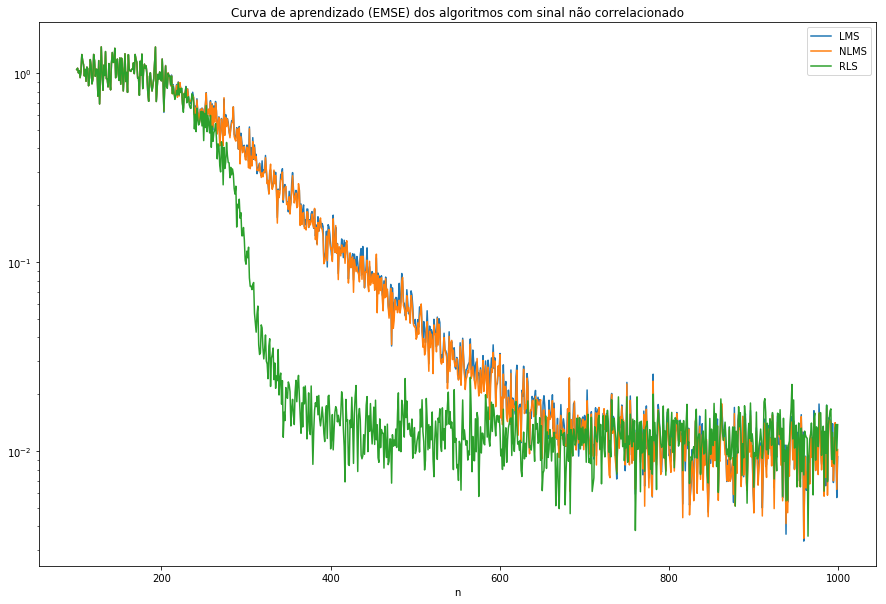

In [3]:
n, EMSE_LMS, EMSE_NLMS, EMSE_RLS = exp5(a=0, mu_0=1, epsilon=0, L=.98, total_time=1000, N=100)
plt.subplots(figsize=(15,10))
plt.semilogy(n, EMSE_LMS, n, EMSE_NLMS, n, EMSE_RLS)
plt.title('Curva de aprendizado (EMSE) dos algoritmos com sinal não correlacionado')
plt.legend(['LMS', 'NLMS', 'RLS'])
plt.xlabel('n')

## Sinal correlacinado

In [8]:
n, EMSE_LMS, EMSE_NLMS, EMSE_RLS = exp5(a=.9, mu_0=.5, epsilon=0, L=.9, total_time=1500, N=100)
plt.subplots(figsize=(15,10))
plt.semilogy(n, EMSE_NLMS, n, EMSE_RLS)
plt.title('Curva de aprendizado (EMSE) dos algoritmos com sinal correlacionado')
plt.legend(['NLMS', 'RLS'])
plt.xlabel('n')

KeyboardInterrupt: 

## Usando sinais de voz

### Importando sinais de voz

Text(0.5, 0, 't (s)')

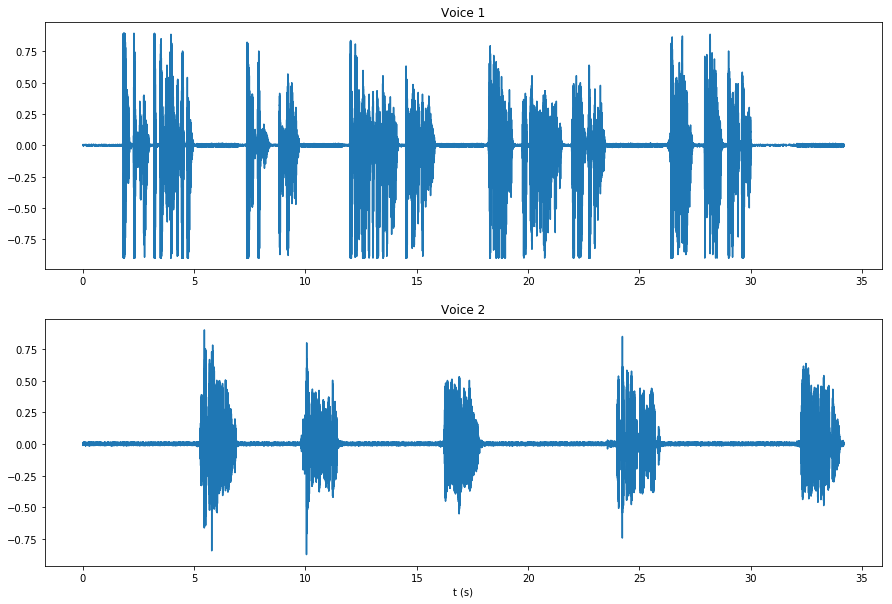

In [9]:
voice_1 = wavfile.read('conversa1.wav')
voice_2 = wavfile.read('conversa2.wav')

#sd.play(voice_2[1], samplerate=voice_2[0])

plt.figure(figsize=(15,10))
ax1 = plt.subplot(211)
plt.plot(np.arange(len(voice_1[1])) * 1 / voice_1[0], voice_1[1])
ax1.title.set_text('Voice 1')
ax2 = plt.subplot(212, sharex=ax1)
plt.plot(np.arange(len(voice_2[1])) * 1 / voice_2[0], voice_2[1])
ax2.title.set_text('Voice 2')
plt.xlabel('t (s)')

### Importando resposta ao impulso do eco

Text(0.5, 0, 'n')

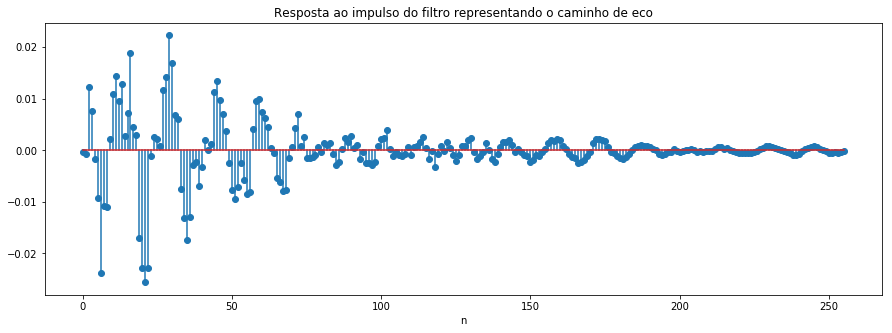

In [10]:
arrays = {}
with h5py.File('respimp.mat') as f:
    for k, v in f.items():
        arrays[k] = np.array(v)
echo_path = arrays['ri256'][0]

plt.figure(figsize=(15, 5))
plt.title('Resposta ao impulso do filtro representando o caminho de eco')
plt.stem(echo_path)
plt.xlabel('n')

### Gerando sinais da simulacao

Text(0.5, 0, 'n')

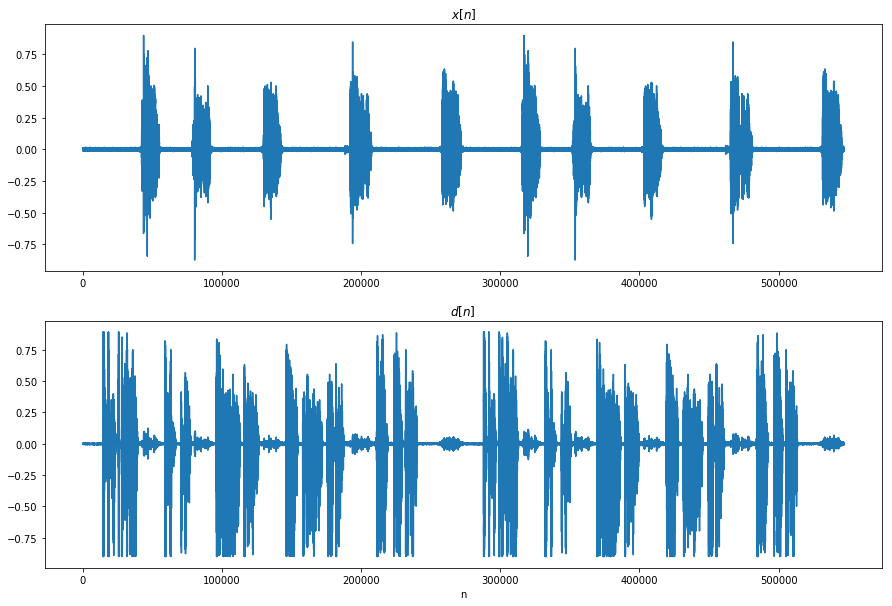

In [59]:
total_samples = len(voice_1[1])
x = voice_2[1][:total_samples]
v = voice_1[1][:total_samples]
h = echo_path
y = signal.lfilter(b=h, a=1, x=x)
y = np.concatenate((y, -y))
x = np.concatenate((x, x))
v = np.concatenate((v, v))
d = y + v

plt.figure(figsize=(15,10))
ax1 = plt.subplot(211)
plt.plot(x)
ax1.title.set_text('$x[n]$')
ax2 = plt.subplot(212, sharex=ax1)
plt.plot(d)
ax2.title.set_text('$d[n]$')
plt.xlabel('n')

### Simulando e salvando resultados

In [ ]:
M = len(h)
nlms_filter = NLMS(M=M, mu_0=.5, epsilon=1e-2)
rls_filter = RLS(M=M, L=.9999, delta=1)

for i in range(len(x)):
    nlms_filter.buffer(x[i], d[i])
    rls_filter.buffer(x[i], d[i])

nlms_delta_W = h - nlms_filter.W
nlms_filter_MSD = np.sum(np.square(nlms_delta_W), axis=1)
rls_delta_W = h - np.squeeze(rls_filter.W)
rls_filter_MSD = np.sum(np.square(rls_delta_W), axis=1)

np.savetxt('./output_files/signals/nlms_filter_e', nlms_filter.e)
np.savetxt('./output_files/signals/nlms_filter_MSD', nlms_filter_MSD)
np.savetxt('./output_files/signals/rls_filter_e', rls_filter.e)
np.savetxt('./output_files/signals/rls_filter_MSD', rls_filter_MSD)

### Plotando filtro NLMS

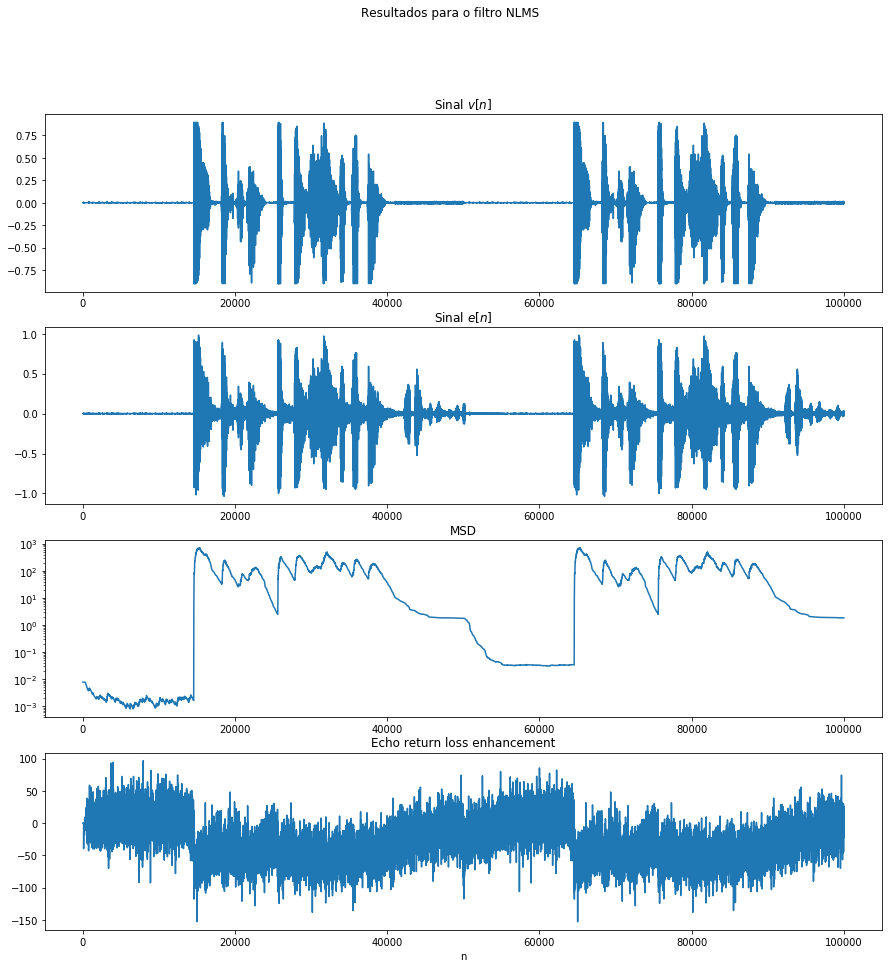

In [42]:
nlms_filter_e = np.loadtxt('nlms_filter_e')
nlms_filter_MSD = np.loadtxt('nlms_filter_MSD')
plot_results('NLMS', nlms_filter_e, nlms_filter_MSD, v, y)

In [52]:
sd.play(nlms_filter_e, samplerate=voice_1[0])

### Resultados RLS

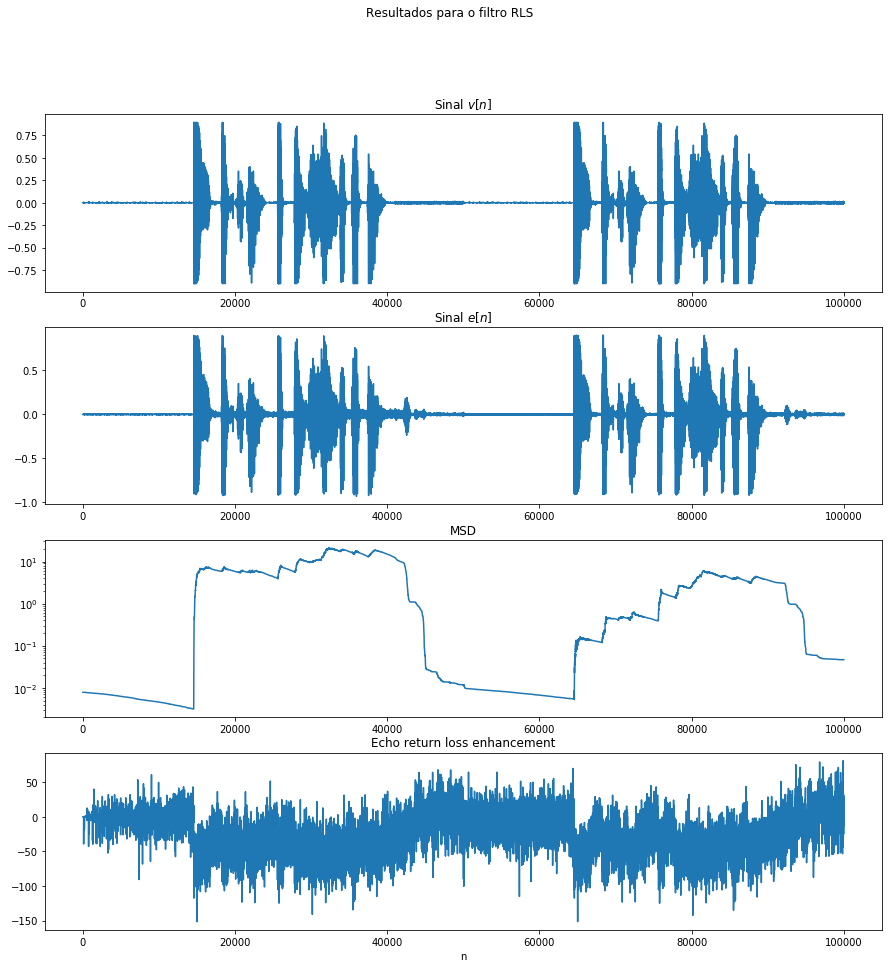

In [43]:
rls_filter_e = np.loadtxt('rls_filter_e')
rls_filter_MSD = np.loadtxt('rls_filter_MSD')
plot_results('RLS', rls_filter_e, rls_filter_MSD, v, y)

In [55]:
sd.play(rls_filter_e, samplerate=voice_1[0])